In [1]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt 

## Data reading

In [2]:
# incarcarea datelor

file = 'data.txt'
data_df = pd.read_csv(file, sep=r'\s+', header=None)
data = data_df.values
data.shape

(11934, 18)

In [3]:
data = np.concatenate((data[:,0:-2], data[:,-1:]),axis=1)
print(data.shape)
assert data.shape == (11934, 17)

(11934, 17)


## Input processing

In [4]:
# Functie pentru separarea datelor de intrare de cele de iesire

def get_input_output(mat: np.array) -> Tuple[np.array, np.array]:
    """Separa partea de intrare (variabile independente) de cea de iesire 
    (variabila dependenta).
    
    :param mat: np.array de forma (m, n). Fiecare linie este un caz 
    inregistrat, adica un vector de intrare. Primele n-1 coloane sunt valori 
    de intrare in model, ultima coloana este valoarea de iesire asociata 
    (ground truth).
    
    :return: un tuplu cu: matrice de (m, n-1) continand intrarile 
    (o linie = un vector de intrare); un vector coloana cu m linii continand
    valorile de iesire asociate intrarilor.
    """
    m, n = mat.shape
    X = mat[:,:-1]
    y = mat[:,-1:]
    assert np.alltrue(X == mat[:, :-1])
    assert np.alltrue(y[:, -1] == mat[:, -1])
    return X, y

In [5]:
# separa matricea cu vectorii de intrare si vectorul coloana cu iesirile asociate
X, y = get_input_output(data)

In [6]:
# Functie pentru scalarea datelor in intervalul [0, 1]. 

def scale_matrix(mat: np.array) -> np.array:
    """Preia o matrice cu valori reale si scaleaza toate coloanele in 
    intervalul [0, 1]. Coloanele constante vor fi transformate in 1.
    
    :param mat: matrice de forma (m, n)
    :return: matrice cu valori scalate in [0, 1]
    """
    
    min_cols, max_cols = np.min(mat,axis=0), np.max(mat,axis=0)
    different_min_max = min_cols!=max_cols

   
    result = np.ones_like(mat)
    result[:, different_min_max] =(mat[:, different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]-min_cols[different_min_max]) 
    assert result.shape == mat.shape
    assert np.alltrue(np.min(result, axis=0) >= 0)
    assert np.alltrue(np.max(result, axis=0) <= 1)
   
    return result, min_cols, max_cols

In [7]:
# Functie pentru scalarea datelor. 
# Scalele sunt furnizate, de regula calculate pe baza datelor din setul 
# de antrenare

def scale_matrix_with_known_minmax(mat: np.array, min_cols: np.array, max_cols: np.array) -> np.array:
    """Preia o matrice  :param mat: si efectueaza scalarea valorilor in 
    intervalul [0, 1] folosind valori de min si max pe fiecare coloana 
    precalculate si date prin parametrii :param min_cols:, :param max_cols:.
    
    :param mat: matricea de (m, n) care trebuie scalata.
    :param min_cols: minime pe coloane, precalculate
    :param max_cols: maxime pe coloane, precalculate
    :return: matrice de (m, n) cu valori scalate.
    """
    different_min_max = min_cols!=max_cols
    result = np.ones_like(mat)
    result[:, different_min_max] = (mat[:, different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]-min_cols[different_min_max])
   
    assert result.shape == mat.shape
    return result

In [8]:
X, min_cols, max_cols =scale_matrix(X) 
y, _, _ =scale_matrix(y)

In [9]:
def design_matrix(mat: np.array) -> np.array:
    """Preia o matrice de forma (m, n) si returneaza o matrice de forma 
    (m, n+1), in care prima coloana este 1, iar ultimele n coloane sunt 
    coloanele lui :param mat:.
    
    :param mat: matrice de forma (m, n)
    :return: matrice de forma (m, n+1), cu prima coloana plina cu 1, ultimele 
    n coloane sunt cele din :param mat:
    """
    m, n = mat.shape
    result = np.insert(mat, 0, 1,axis=1)
    assert result.shape == (m, n+1)
    assert np.alltrue(result[:, 0] == 1)
    assert np.alltrue(result[:, 1:] == mat)
    return result

In [10]:
X = design_matrix(X)

## Linear regression with stochastic gradient descent


### Model implementation

In [11]:
def h(X: np.array, w: np.array) -> np.array:
    """Pentru un model liniar specificat prin parametrii w si un set de date 
    de intrare X produce valorile estimate de model: 
    y_hat[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + ...  
   
   :param X: valori de intrare, structurate ca np.array de forma (m, n)
   :param w: vector de ponderi, de forma (n, 1)
   :return: vector cu valori de iesire estimate, de forma (n, 1). 
    """
    assert w.shape == (X.shape[1], 1)
    assert X.shape[1] == w.shape[0]
    y_hat = np.dot(X,w)
    assert y_hat.shape == (X.shape[0], 1)
    return y_hat

### MSE function

In [12]:
def mean_squared_error(y: np.array, y_hat: np.array) -> float:
    """Functie de eroare patratica medie.
    
    :param y: vector coloana de m elemente, continand valorile de iesire reale 
    (ground truth)
    :param y_hat': vector coloana de m elemente, continand valorile de iesire
    estimate.
    :return: eroarea patratica medie.
    """
    result = np.square(np.subtract(y_hat,y)).mean() 
    return result

### Cost function

In [13]:
# Functia de eroare

def J(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> float:
    """Calculeaza valoarea functiei de eroare pentru intrarea curenta :param X:, 
    estimarea produsa de model folosind ponderile :param w: si iesirea corecta
    :param y: (ground truth).
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: jumatate din mean squared error plus penalizarea L2
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m = X.shape[0]
    y_hat = np.dot(X,w)  
    assert y_hat.shape == (X.shape[0], 1)
    term_squared_error = mean_squared_error(y,y_hat)/2   
    l2_error = lmbda * np.sum(np.power(w[1:], 2))
    return term_squared_error + l2_error

### Stochastic gradient descent implementation

In [14]:
def gradient(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> np.array:
    """Calculeaza gradientul functiei de eroare
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: vector gradient
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m, _ = X.shape
    y_hat = np.dot(X,w) 
    
    grad=1/m*np.dot(np.transpose(X),y_hat-y)
    grad[1:, ] += lmbda*w[1:,] 
    grad = grad.astype('float32')
    assert grad.shape == w.shape
    return grad

In [15]:
# Implementarea algoritmului de antrenare

def train(X:np.array, y:np.array, max_iters:int = 100000, alpha:float = 0.001, lmbda: float = 0.01) -> Tuple[np.array, List[float]]:
    """Aplica algoritmul de instruire cu gradient. 
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param alpha: rata de invatare
    :param lmda: coeficientul de penalizare L2
    :return: tuplu continand ponderile modelului rezultate dupa instruire, lista de erori pe setul de antrenare
    """
    m, n = X.shape
    assert y.shape == (m, 1)
    assert X.shape[0] == y.shape[0]
    w = np.full((n, 1), 0) 
    losses = [None] * max_iters
    
    for i in range(max_iters):
        loss = J(X,w,y,lmbda) 
        if i%1000==0:
            print(f'index {i} error: {loss}')
        nr =0   
        losses[i] = loss
        grad =  gradient(X,w,y,lmbda)  
        w=w.astype('float32')
        grad=grad.astype('float32')
        w -= np.multiply(alpha, grad) 
        
    return w, losses

In [16]:
w, losses = train(X, y, max_iters=100000, alpha=0.25,lmbda=0.0)

index 0 error: 0.16999999999999998
index 1000 error: 0.04233323394627544
index 2000 error: 0.040933810924700734
index 3000 error: 0.04002624636978923
index 4000 error: 0.03933820766446256
index 5000 error: 0.03876246436014073
index 6000 error: 0.03825019227115656
index 7000 error: 0.0377767837013462
index 8000 error: 0.037328974133299775
index 9000 error: 0.036899292956229936
index 10000 error: 0.03648337579445867
index 11000 error: 0.036078599744505425
index 12000 error: 0.03568333632096272
index 13000 error: 0.035296543664943135
index 14000 error: 0.03491751903540715
index 15000 error: 0.03454577223584518
index 16000 error: 0.034180956232748694
index 17000 error: 0.03382276227682325
index 18000 error: 0.033470959221046974
index 19000 error: 0.03312534905182084
index 20000 error: 0.03278576770096069
index 21000 error: 0.0324520423717688
index 22000 error: 0.032124025473498144
index 23000 error: 0.03180157594340891
index 24000 error: 0.03148455774880778
index 25000 error: 0.03117282337

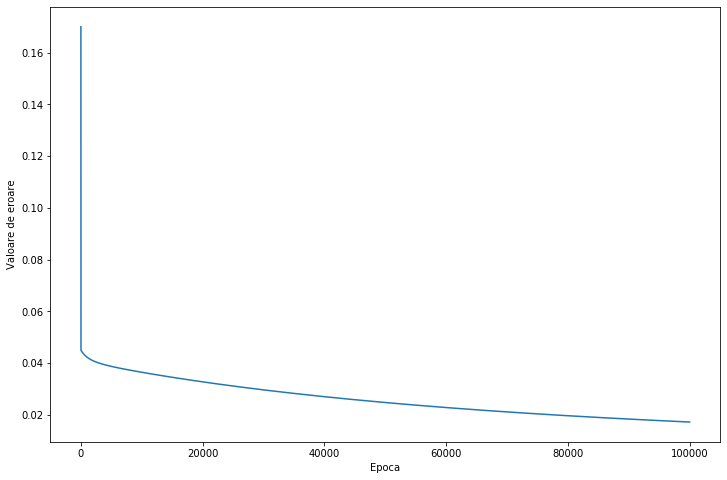

In [17]:
# desenarea curbei de cost pe setul de antrenare

plt.figure(figsize=(12, 8))
plt.xlabel('Epoca')
plt.ylabel('Valoare de eroare')
plt.plot(losses)

In [18]:
# Obtine valorile estimate de model, calculeaza eroarea intre estimare si 
# ground truth.

# estimare facuta de model
y_hat = h(X,w)
# mean squared error pe setul de antrenare
error_sgd = mean_squared_error(y,y_hat)

print('Eroarea determinata prin algoritmul stochastic gradient descent:', error_sgd)
print('Vectorul de ponderi:', w[:, 0])

Eroarea determinata prin algoritmul stochastic gradient descent: 0.03452710322128866
Vectorul de ponderi: [  0.22497468   0.36307207   0.20600656  11.176838     2.660374
   1.3089219   -2.9550188   -2.9550188   -1.3089412    0.22497468
   0.8542994    3.5726602    0.22497468 -19.194073     5.1006675
   0.15175103   0.6051867 ]


### Pseudoinverse method

In [19]:
# se calculeaza w cu metoda pseudoinversei 
w_pinv = np.dot(np.linalg.pinv(X),y)
# se calculeaza estimarea data cu ponderile w_pinv
y_hat_pinv = h(X,w_pinv)

# se calculeaza eroarea patratica medie
error_pinv = mean_squared_error(y,y_hat_pinv)
print('Eroarea determinata prin metoda pseudoinversei:', error_pinv)

Eroarea determinata prin metoda pseudoinversei: 0.008010137201200612


In [20]:
print(np.linalg.norm(gradient(X, w_pinv, y)))

1.7378978e-14


In [21]:
# afiseaza ponderile determinate prin metoda pseudoinversei

print(w_pinv[:, 0])

[  0.29015495   0.39839967   5.56767682  40.06318117   5.89697855
   4.03988449 -20.25484653 -20.25484653 -18.34254684   0.29015495
   1.81835155  11.32697686   0.29015495 -37.23147039   1.22929938
  -0.88382777  25.32182337]


## Split validation

In [22]:
# imparte setul initial in 70% antrenare si 30% testare
data = np.random.permutation(data)
split_percentage = 0.7

split_index = int(split_percentage * data.shape[0])

data_train = data[0:split_index,]
data_test = data[split_index:,]

X_train, y_train = get_input_output(data_train)
X_test, y_test = get_input_output(data_test)

In [23]:
# scaleaza datele de intrare din setul de antrenare si obtine minimele 
# si maximele pe coloane 
X_train, min_X_train, max_X_train = scale_matrix(X_train)
# scaleaza datele de iesire din setul de antrenare si obtine minimul si 
# maximul pe coloana
y_train, min_y_train, max_y_train = scale_matrix(y_train)

In [24]:
# scaleaza datele de intrare din setul de test, folosind minimele si maximele 
# pe coloane aflate de la X_train 
X_test = scale_matrix_with_known_minmax(X_test, min_X_train, max_X_train)

# scaleaza datele de iesire din setul de test, folosind minimul si maximul 
# pe coloana aflate de la y_train
y_test = scale_matrix_with_known_minmax(y_test, min_y_train, max_y_train)

In [25]:
# antreneaza linear regression pe setul de antrenare, obtine ponderile
# modelului
w_train, losses_train = train(X_train, y_train, max_iters=100000, alpha=0.25,lmbda=0.0)
# restul parametrilor ca la apelul de antrenare de mai sus

index 0 error: 0.17024398419729442
index 1000 error: 0.0422720319483041
index 2000 error: 0.040912553438164856
index 3000 error: 0.040017088066858275
index 4000 error: 0.03933370971261628
index 5000 error: 0.03876019580521063
index 6000 error: 0.03824908535863709
index 7000 error: 0.037776212055581064
index 8000 error: 0.03732851902322338
index 9000 error: 0.03689864428985939
index 10000 error: 0.0364823081925935
index 11000 error: 0.03607694943614913
index 12000 error: 0.035680984326155275
index 13000 error: 0.03529340262196641
index 14000 error: 0.03491353674784508
index 15000 error: 0.03454091952139471
index 16000 error: 0.034175204324107464
index 17000 error: 0.03381610199345633
index 18000 error: 0.03346341881039652
index 19000 error: 0.03311694674270607
index 20000 error: 0.03277650131914706
index 21000 error: 0.032441955147641324
index 22000 error: 0.032113156344552925
index 23000 error: 0.031789953095626856
index 24000 error: 0.03147223074421533
index 25000 error: 0.03115985065

In [26]:
# obtine estimarile date de model pe setul de testare
y_hat_test =  h(X_test,w_train)
print('MSE pentru setul de testare:', mean_squared_error(y_test, y_hat_test))

MSE pentru setul de testare: 0.03462588451082689


Text(0, 0.5, 'Diferenta intre ground truth si valoarea estimata')

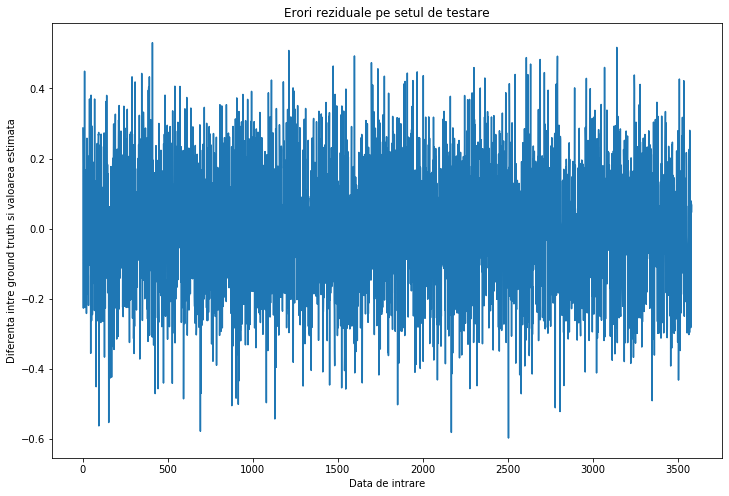

In [27]:
# reprezentarea diferentei intre ground truth si estimare pe setul de testare
plt.figure(figsize=(12, 8))
plt.title('Erori reziduale pe setul de testare')
plt.plot(y_test - y_hat_test)
plt.xlabel('Data de intrare')
plt.ylabel('Diferenta intre ground truth si valoarea estimata')